In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render ul li{font-size:22pt; line-height:30px;}
div.output {font-size:22pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:22pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:22pt;padding:5px;}
table.dataframe{font-size:22px;}
</style>
"""))

In [13]:
# ============================================================
# [단락 0] 라이브러리
# ============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ===============================
# 📌 한글 폰트 설정 (Windows)
# ===============================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ============================================================
# [단락 1] 데이터 로드
# ============================================================
path = r"C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리_폐업률머지.csv"
df = pd.read_csv(path, low_memory=False)

print(df.shape)
print(df[["구", "업태_그룹", "폐업률_3년이내_pct"]].head())

(241267, 24)
     구   업태_그룹  폐업률_3년이내_pct
0  은평구      기타          31.0
1  은평구      한식          33.2
2  서초구  분식/간편식          39.7
3  서초구   양식/외식          30.0
4   중구   주점/치킨          24.5


In [4]:
# ============================================================
# [단락 2] (구, 업태_그룹) 조합을 유니크하게 만들기
#  - 폐업률_3년이내_pct는 (구,업태) 조합별로 동일하므로
#    조합당 1개 행만 남겨 학습 데이터로 사용
# ============================================================
g = (
    df[["구", "업태_그룹", "폐업률_3년이내_pct"]]
      .dropna()
      .groupby(["구", "업태_그룹"], as_index=False)
      .agg({"폐업률_3년이내_pct": "first"})
)

y = g["폐업률_3년이내_pct"].astype("float32").values

print("유니크 조합 수:", len(g))
print(g.head())


유니크 조합 수: 175
     구   업태_그룹  폐업률_3년이내_pct
0  강남구      기타          38.3
1  강남구  분식/간편식          34.0
2  강남구   양식/외식          30.3
3  강남구   주점/치킨          33.3
4  강남구    중/일식          28.1


In [5]:
# ============================================================
# [단락 3] 라벨(정수) 인코딩
#  - 문자열 범주(구/업태)를 정수 ID로 변환
#  - Embedding 레이어에 넣기 위해 필요
# ============================================================
g["구_id"], gu_vocab = pd.factorize(g["구"])
g["업태_id"], biz_vocab = pd.factorize(g["업태_그룹"])

X_gu = g["구_id"].astype("int32").values
X_biz = g["업태_id"].astype("int32").values

n_gu = len(gu_vocab)
n_biz = len(biz_vocab)

print("구 종류 수:", n_gu, "| 업태_그룹 종류 수:", n_biz)


구 종류 수: 25 | 업태_그룹 종류 수: 7


In [6]:
# ============================================================
# [단락 4] Train / Val / Test split
# ============================================================
idx = np.arange(len(g))
tr, te = train_test_split(idx, test_size=0.2, random_state=42)
tr, va = train_test_split(tr, test_size=0.2, random_state=42)

X_tr = {"gu": X_gu[tr], "biz": X_biz[tr]}
X_va = {"gu": X_gu[va], "biz": X_biz[va]}
X_te = {"gu": X_gu[te], "biz": X_biz[te]}

y_tr, y_va, y_te = y[tr], y[va], y[te]

print("train/val/test size:", len(tr), len(va), len(te))


train/val/test size: 112 28 35


In [7]:
# ============================================================
# [단락 5] 모델 정의 (Embedding + Dense) : 회귀
#  - 입력: 구_id, 업태_id (정수)
#  - 출력: 폐업률_3년이내_pct (연속값) 1개
# ============================================================
def emb_dim(vocab_size: int) -> int:
    # 작은 범주 수에서는 너무 큰 임베딩은 과적합이 쉬움 → 적당히 제한
    return int(min(16, max(4, round(vocab_size ** 0.5))))

gu_in  = keras.Input(shape=(), dtype=tf.int32, name="gu")
biz_in = keras.Input(shape=(), dtype=tf.int32, name="biz")

gu_emb  = layers.Embedding(input_dim=n_gu + 1,  output_dim=emb_dim(n_gu + 1))(gu_in)
biz_emb = layers.Embedding(input_dim=n_biz + 1, output_dim=emb_dim(n_biz + 1))(biz_in)

x = layers.Concatenate()([layers.Flatten()(gu_emb), layers.Flatten()(biz_emb)])
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="relu")(x)

out = layers.Dense(1, activation="linear")(x)

model = keras.Model(inputs=[gu_in, biz_in], outputs=out)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[keras.metrics.MAE]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gu (InputLayer)                [(None,)]            0           []                               
                                                                                                  
 biz (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5)            130         ['gu[0][0]']                     
                                                                                                  
 embedding_1 (Embedding)        (None, 4)            32          ['biz[0][0]']                    
                                                                                              

In [8]:
# ============================================================
# [단락 6] 학습 (가중치 없음)
# ============================================================
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/300
4/4 [==============================] - 1s 55ms/step - loss: 1017.7795 - mean_absolute_error: 31.4102 - val_loss: 978.5908 - val_mean_absolute_error: 30.7835
Epoch 2/300
4/4 [==============================] - 0s 11ms/step - loss: 1016.3541 - mean_absolute_error: 31.3877 - val_loss: 977.0282 - val_mean_absolute_error: 30.7583
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 1014.6395 - mean_absolute_error: 31.3606 - val_loss: 975.2160 - val_mean_absolute_error: 30.7289
Epoch 4/300
4/4 [==============================] - 0s 7ms/step - loss: 1012.8199 - mean_absolute_error: 31.3310 - val_loss: 973.1661 - val_mean_absolute_error: 30.6956
Epoch 5/300
4/4 [==============================] - 0s 7ms/step - loss: 1010.6873 - mean_absolute_error: 31.2969 - val_loss: 970.8532 - val_mean_absolute_error: 30.6579
Epoch 6/300
4/4 [==============================] - 0s 12ms/step - loss: 1008.3434 - mean_absolute_error: 31.2593 - val_loss: 968.2691 - val_mean_absolute_erro

Epoch 50/300
4/4 [==============================] - 0s 5ms/step - loss: 41.8898 - mean_absolute_error: 4.9171 - val_loss: 21.7918 - val_mean_absolute_error: 3.4404
Epoch 51/300
4/4 [==============================] - 0s 7ms/step - loss: 45.1080 - mean_absolute_error: 5.2715 - val_loss: 21.1906 - val_mean_absolute_error: 3.4197
Epoch 52/300
4/4 [==============================] - 0s 10ms/step - loss: 37.2401 - mean_absolute_error: 4.8159 - val_loss: 20.6996 - val_mean_absolute_error: 3.3963
Epoch 53/300
4/4 [==============================] - 0s 11ms/step - loss: 35.2042 - mean_absolute_error: 4.7595 - val_loss: 20.1863 - val_mean_absolute_error: 3.3594
Epoch 54/300
4/4 [==============================] - 0s 9ms/step - loss: 37.0179 - mean_absolute_error: 4.8542 - val_loss: 19.6458 - val_mean_absolute_error: 3.3067
Epoch 55/300
4/4 [==============================] - 0s 5ms/step - loss: 37.8005 - mean_absolute_error: 4.7708 - val_loss: 19.0519 - val_mean_absolute_error: 3.2481
Epoch 56/300
4

Epoch 100/300
4/4 [==============================] - 0s 7ms/step - loss: 18.5070 - mean_absolute_error: 3.5313 - val_loss: 12.7613 - val_mean_absolute_error: 3.0397
Epoch 101/300
4/4 [==============================] - 0s 13ms/step - loss: 21.7350 - mean_absolute_error: 3.6410 - val_loss: 12.7001 - val_mean_absolute_error: 3.0451
Epoch 102/300
4/4 [==============================] - 0s 9ms/step - loss: 21.4083 - mean_absolute_error: 3.5794 - val_loss: 12.6650 - val_mean_absolute_error: 3.0540
Epoch 103/300
4/4 [==============================] - 0s 9ms/step - loss: 15.4034 - mean_absolute_error: 3.1043 - val_loss: 12.6092 - val_mean_absolute_error: 3.0596
Epoch 104/300
4/4 [==============================] - 0s 7ms/step - loss: 14.6758 - mean_absolute_error: 3.0443 - val_loss: 12.5541 - val_mean_absolute_error: 3.0652
Epoch 105/300
4/4 [==============================] - 0s 6ms/step - loss: 17.6271 - mean_absolute_error: 3.2038 - val_loss: 12.5269 - val_mean_absolute_error: 3.0702
Epoch 106

In [9]:
# ============================================================
# [단락 7] 평가 + 예측 일부 출력
# ============================================================
res = model.evaluate(X_te, y_te, verbose=0)
print("\n[Test] MSE, MAE =", res)

pred = model.predict(X_te, verbose=0).reshape(-1)

print("\n예측 vs 실제(10개)")
for p, t in list(zip(pred[:10], y_te[:10])):
    print(f"pred={p:.1f}%  true={t:.1f}%")



[Test] MSE, MAE = [10.633523941040039, 2.6790971755981445]

예측 vs 실제(10개)
pred=21.3%  true=23.2%
pred=22.8%  true=24.6%
pred=27.7%  true=28.6%
pred=43.3%  true=48.0%
pred=32.6%  true=30.6%
pred=31.6%  true=27.9%
pred=36.7%  true=37.2%
pred=38.1%  true=45.6%
pred=37.6%  true=37.3%
pred=32.9%  true=36.5%


In [10]:
# ============================================================
# [단락 8] 검증(Val) 예측 결과 출력 (구/업태 이름 포함, 오차 큰 순)
#  - 소수점 1자리로 "표시" 강제
# ============================================================
pred_va = model.predict(X_va, verbose=0).reshape(-1)

# 검증 지표(소수 1자리 출력)
mae_va  = float(np.mean(np.abs(pred_va - y_va)))
mse_va  = float(np.mean((pred_va - y_va) ** 2))
rmse_va = float(np.sqrt(mse_va))

print(f"\n[Validation] MAE = {mae_va:.1f} | RMSE = {rmse_va:.1f} | MSE = {mse_va:.1f}")

# va 인덱스에 해당하는 (구, 업태_그룹) 가져오기
val_result = g.iloc[va][["구", "업태_그룹"]].copy()
val_result["true_pct"] = y_va
val_result["pred_pct"] = pred_va
val_result["abs_error"] = np.abs(val_result["pred_pct"] - val_result["true_pct"])

# ✅ 출력용: 소수 1자리로 강제 표시(문자열 포맷)
val_result["true_pct"]  = val_result["true_pct"].map(lambda x: f"{x:.1f}")
val_result["pred_pct"]  = val_result["pred_pct"].map(lambda x: f"{x:.1f}")
val_result["abs_error"] = val_result["abs_error"].map(lambda x: f"{x:.1f}")

print("\n[검증 예측 결과]")
print(val_result.to_string(index=False))

print("\n[오차 큰 순]")
print(val_result.sort_values("abs_error", ascending=False).to_string(index=False))



[Validation] MAE = 3.1 | RMSE = 3.5 | MSE = 12.5

[검증 예측 결과]
   구  업태_그룹 true_pct pred_pct abs_error
 도봉구     기타     32.1     34.7       2.6
 관악구     카페     31.7     30.1       1.6
 동작구     카페     29.6     25.7       3.9
 양천구  주점/치킨     34.1     34.9       0.8
 송파구     카페     33.1     29.4       3.7
동대문구     카페     24.6     30.2       5.6
 금천구     기타     32.5     35.0       2.5
영등포구  주점/치킨     31.1     30.3       0.8
 은평구     한식     33.2     32.7       0.5
 금천구     카페     25.7     30.9       5.2
 노원구  양식/외식     29.7     31.2       1.5
 서초구  양식/외식     30.0     28.5       1.5
동대문구  주점/치킨     29.9     31.6       1.7
 광진구 분식/간편식     43.3     36.5       6.8
 송파구  양식/외식     35.0     31.6       3.4
 종로구  주점/치킨     24.3     20.4       3.9
 종로구     카페     19.9     19.1       0.8
서대문구     한식     27.8     30.9       3.1
 서초구     카페     31.2     26.3       4.9
 성동구  양식/외식     27.4     30.4       3.0
  중구     카페     24.0     27.1       3.1
 중랑구 분식/간편식     45.1     39.2       5.9
 은평구     기타     31

In [15]:
# ============================================================
# [단락 8] 검증/테스트 예측값 생성
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

pred_va = model.predict(X_va, verbose=0).reshape(-1)
pred_te = model.predict(X_te, verbose=0).reshape(-1)

# (선택) %값이라 0~100 범위로 클리핑(튀는 값 방지)
pred_va = np.clip(pred_va, 0, 100)
pred_te = np.clip(pred_te, 0, 100)


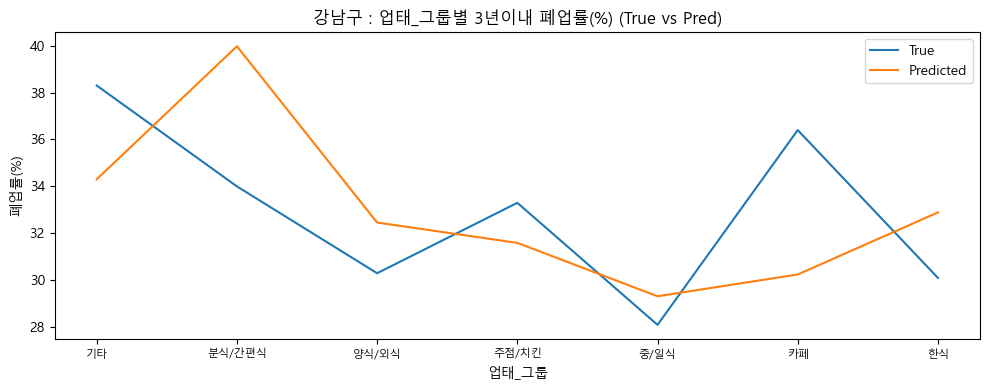

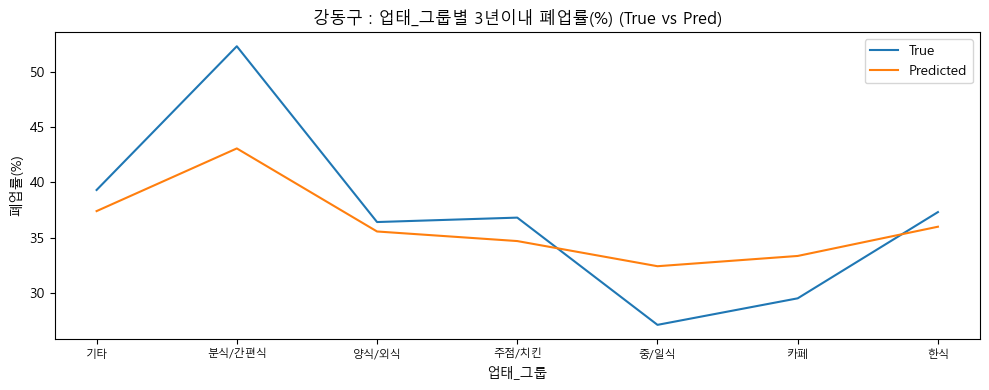

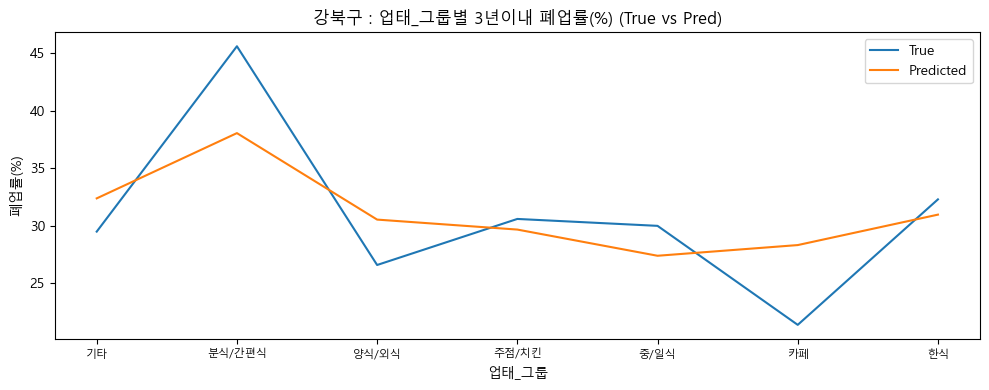

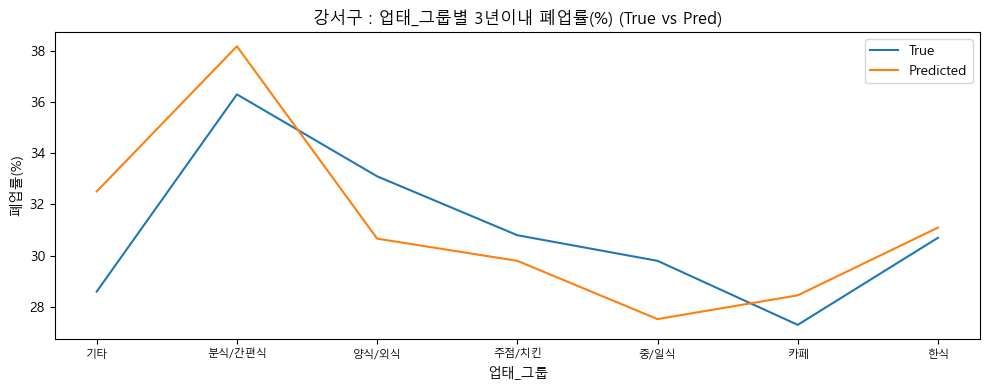

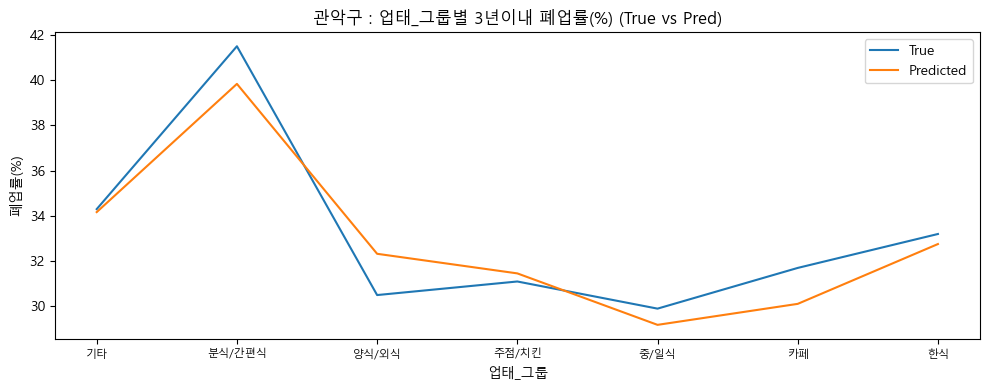

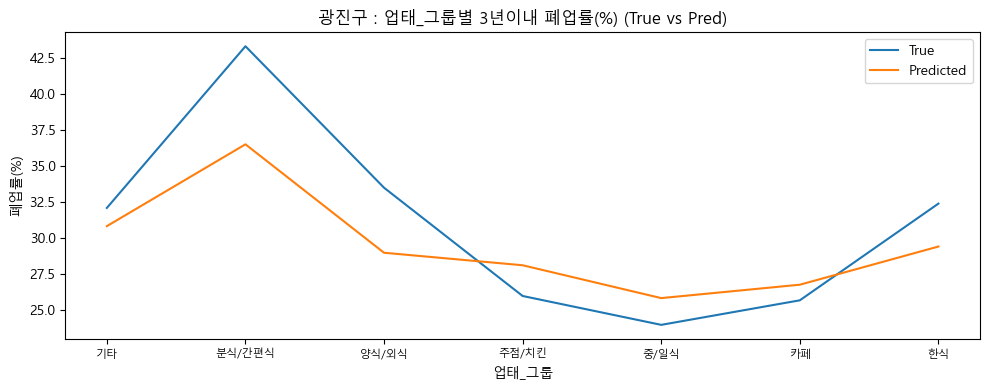

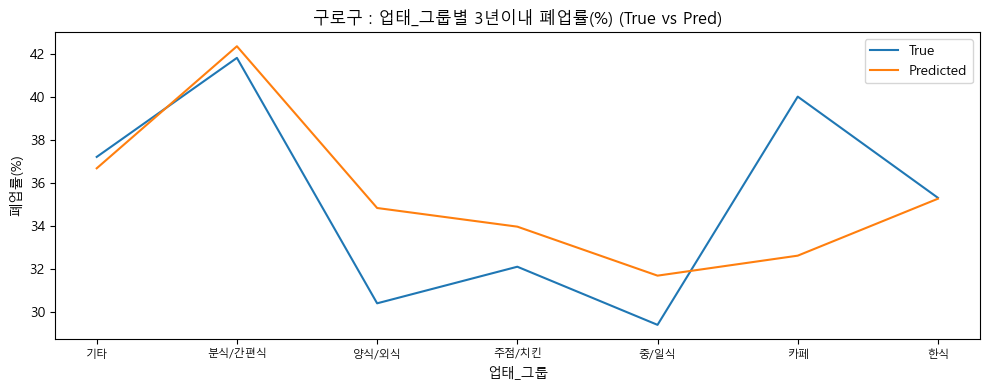

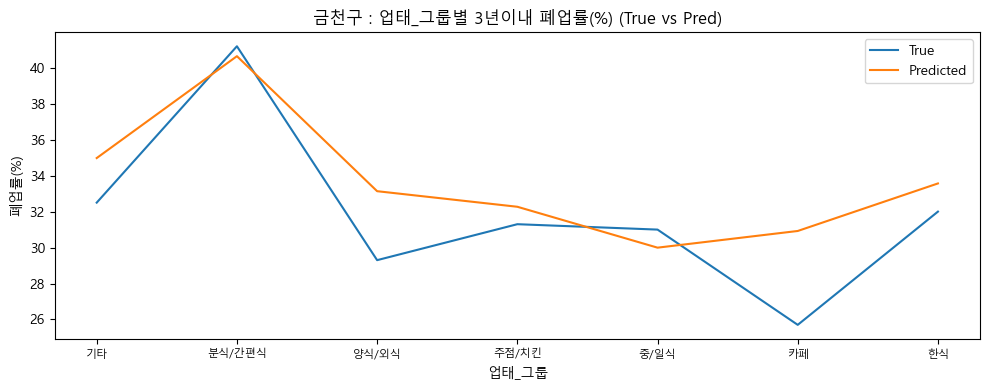

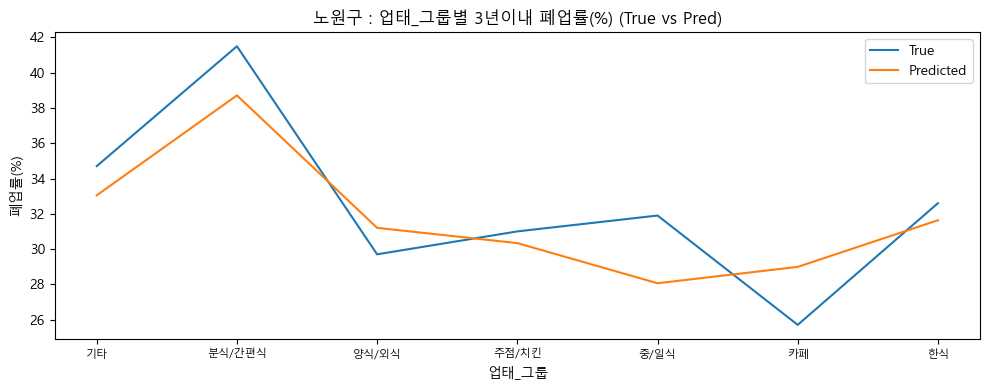

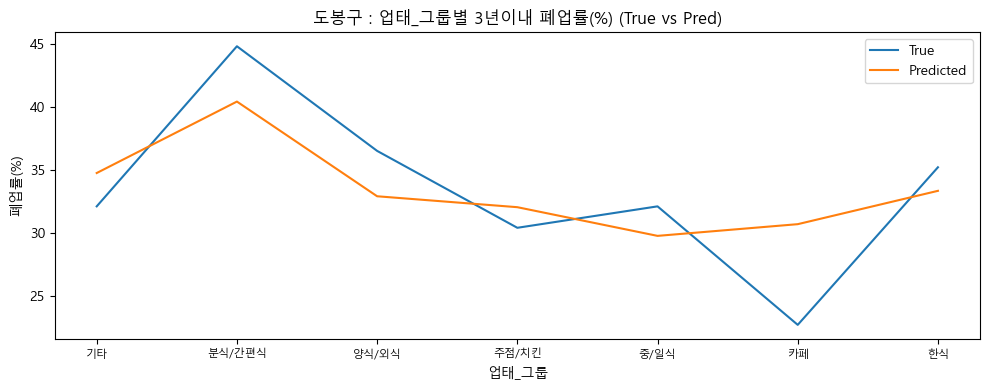

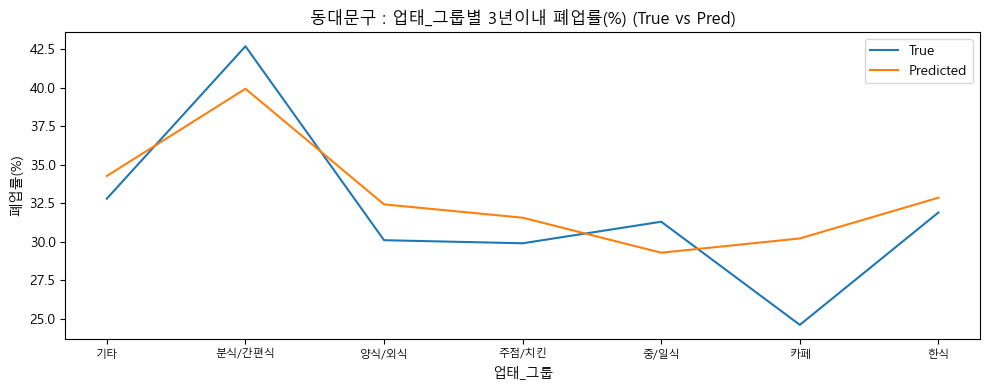

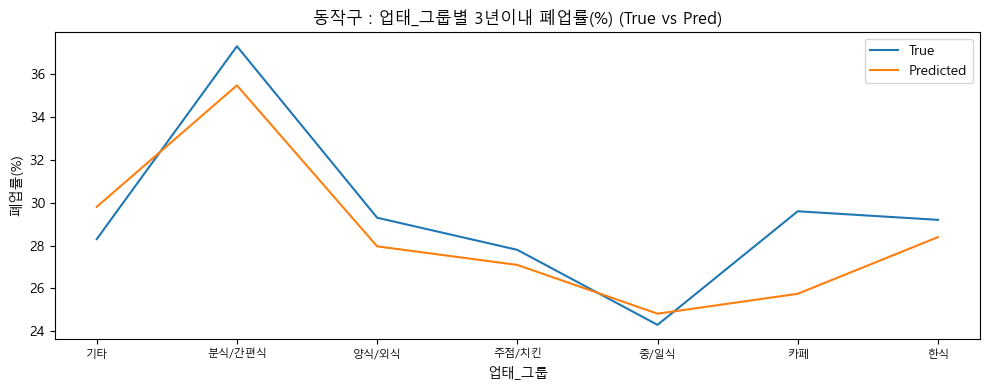

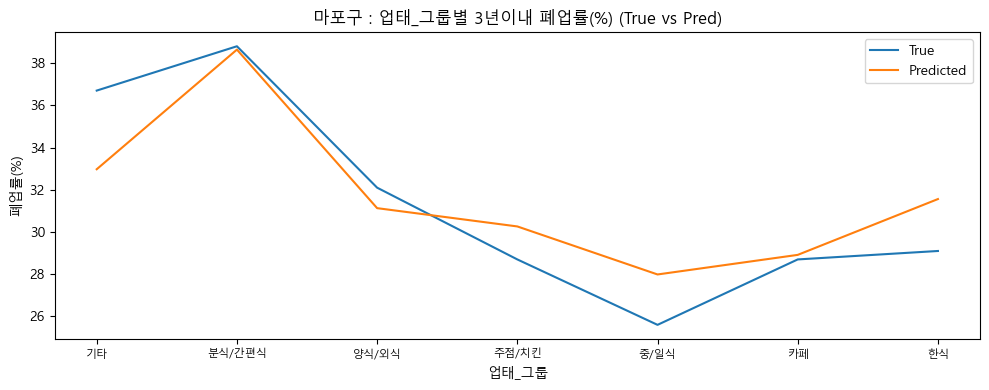

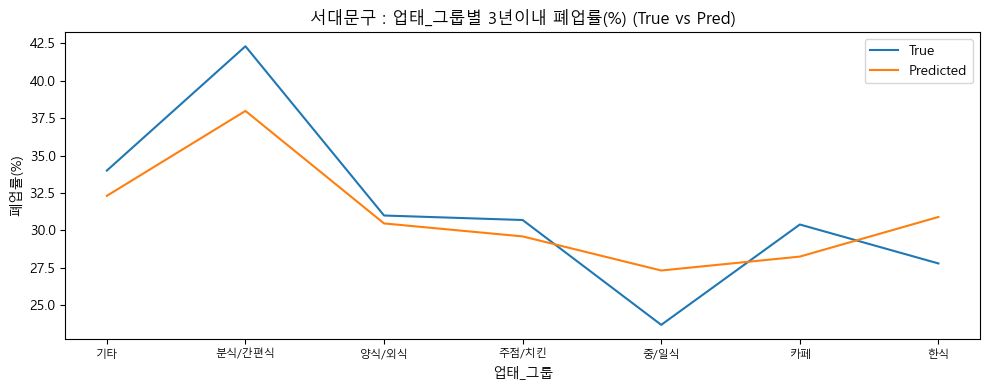

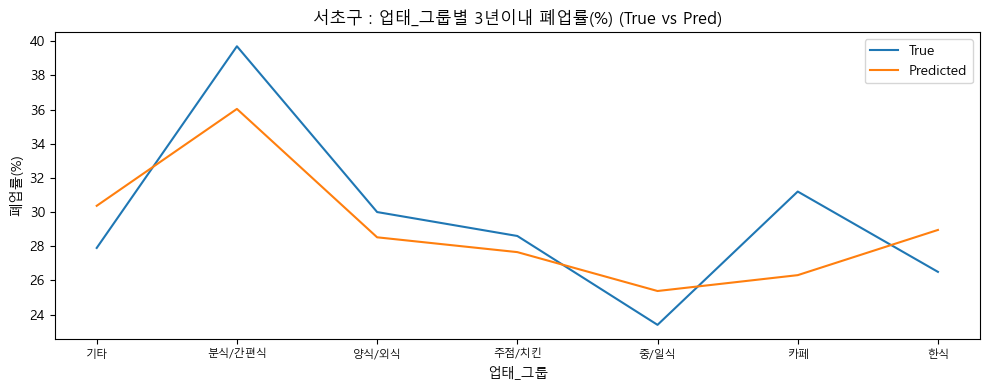

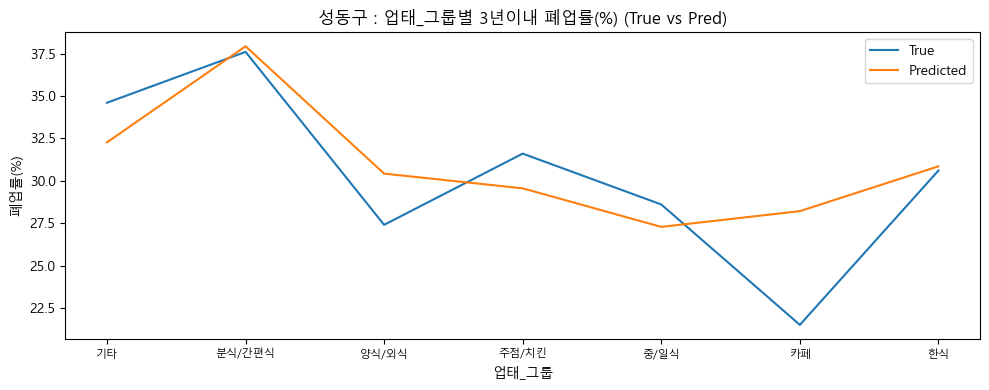

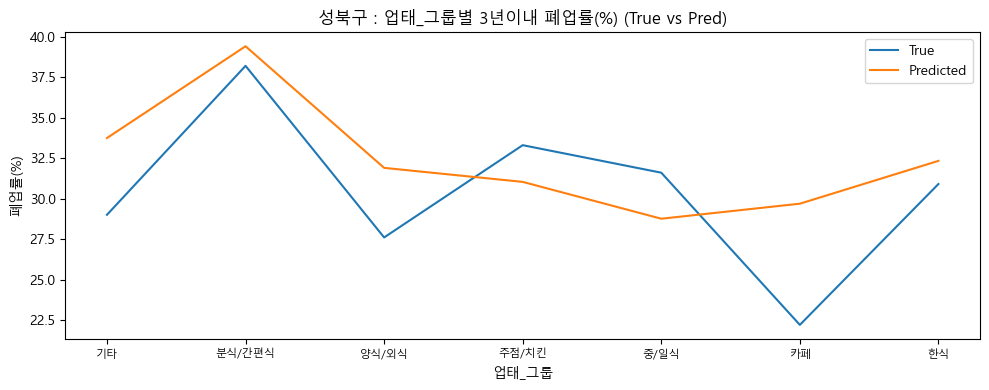

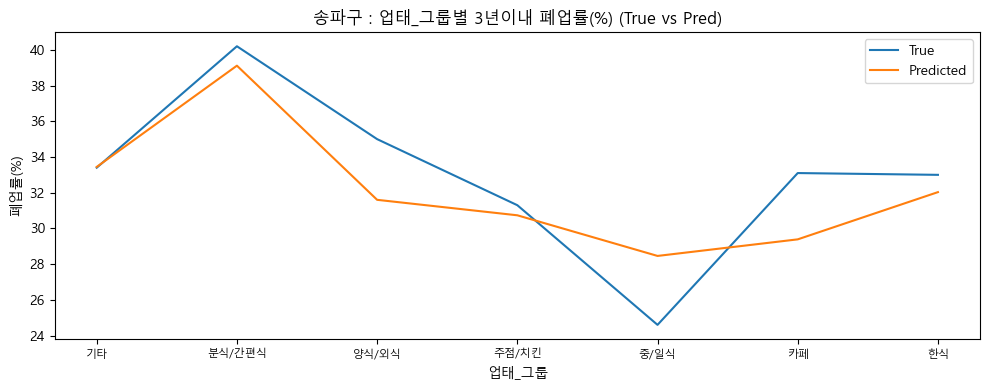

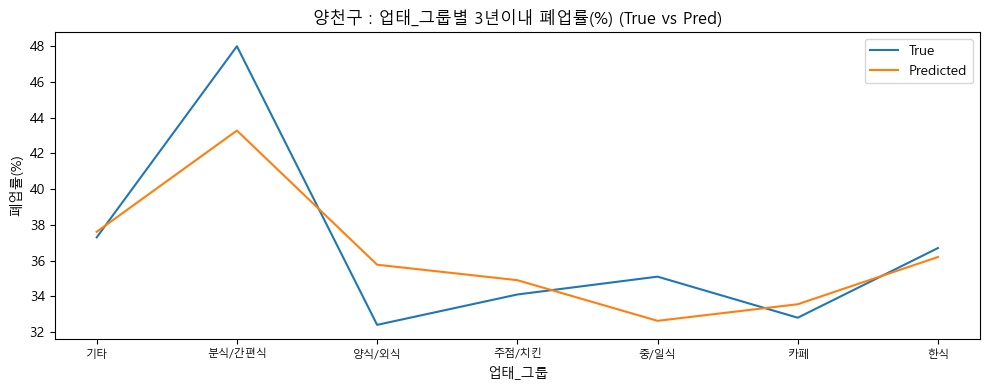

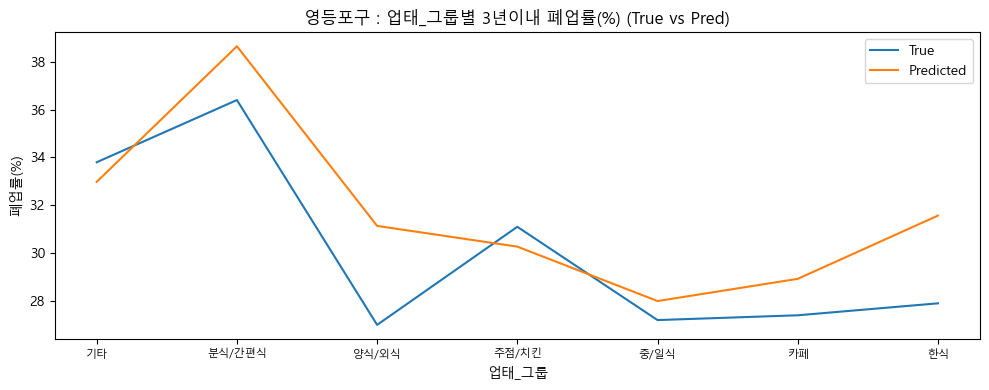

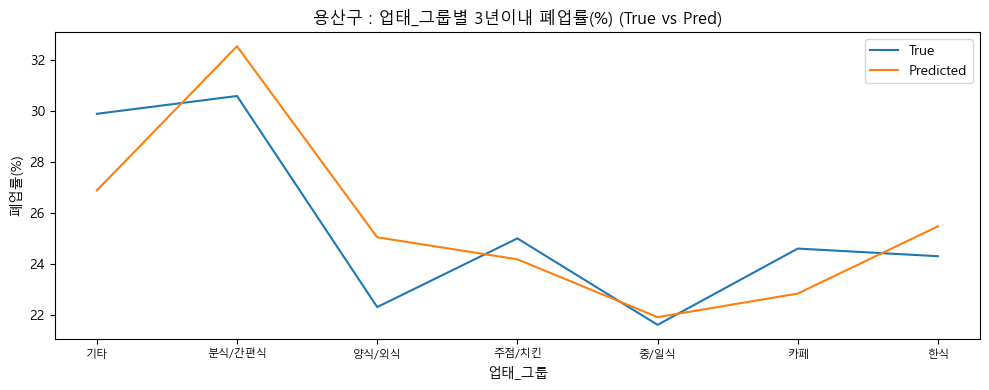

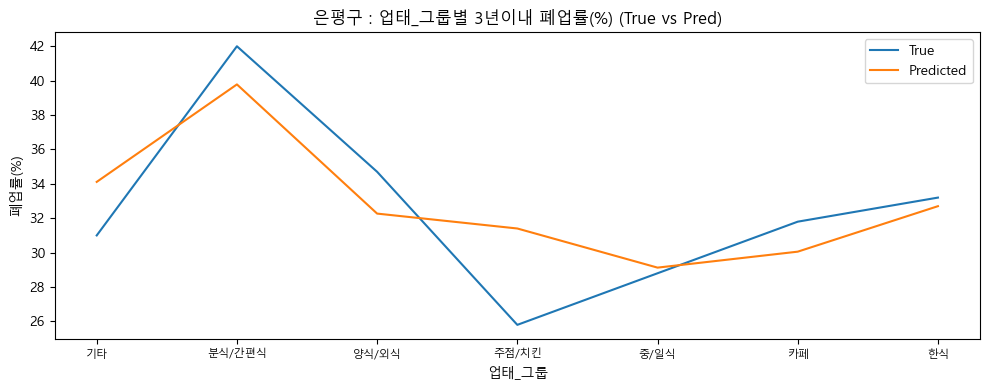

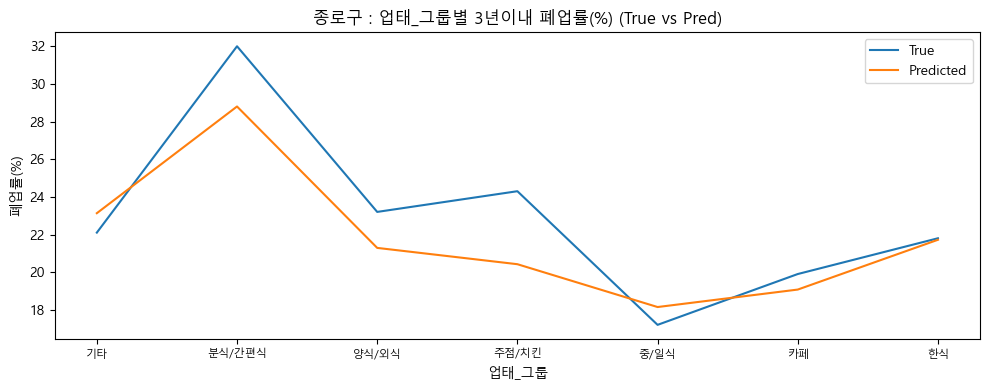

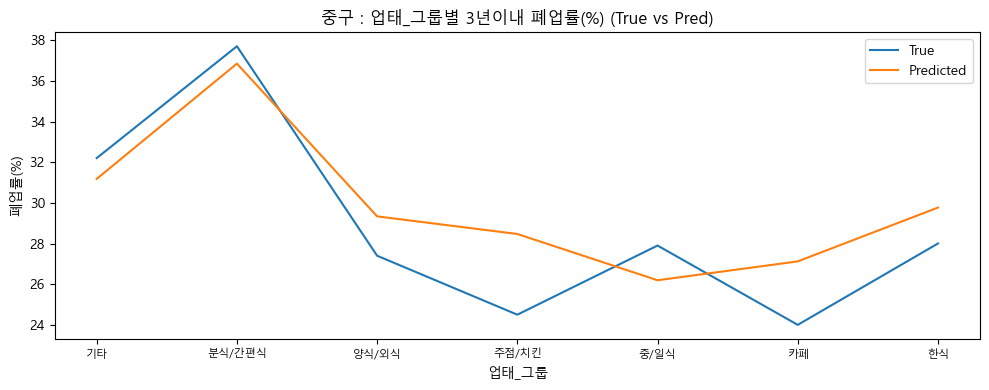

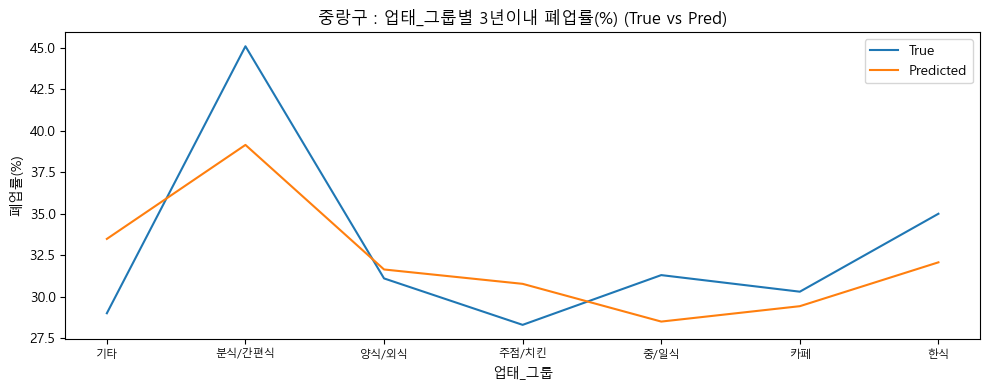

In [18]:
# ============================================================
# [단락 9] 구별 라인그래프: True(실제) vs Pred(예측) — 다른 색으로 표시
#  - 라벨인코딩(Embedding) 모델용: model.predict({"gu":..., "biz":...})
#  - 전제: g, X_gu, X_biz, model 존재
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# ✅ 전체(구×업태) 조합 예측값 만들기 (g와 같은 순서)
X_all = {
    "gu": X_gu.astype(np.int32),
    "biz": X_biz.astype(np.int32)
}
pred_all = model.predict(X_all, verbose=0).reshape(-1)
pred_all = np.clip(pred_all, 0, 100)  # %라서 안전하게(선택)

tmp = g.copy()
tmp["pred_pct"] = pred_all

gus = sorted(tmp["구"].dropna().unique())

for gu in gus:
    d = tmp[tmp["구"] == gu].copy()
    d = d.sort_values("업태_그룹").reset_index(drop=True)

    labels = d["업태_그룹"].astype(str).tolist()
    true_v = d["폐업률_3년이내_pct"].astype(float).values
    pred_v = d["pred_pct"].astype(float).values
    x = np.arange(len(d))

    fig_w = max(10, len(d) * 0.7)

    plt.figure(figsize=(fig_w, 4))
    plt.plot(x, true_v, label="True", color="tab:blue")
    plt.plot(x, pred_v, label="Predicted", color="tab:orange")

    plt.title(f"{gu} : 업태_그룹별 3년이내 폐업률(%) (True vs Pred)")
    plt.xlabel("업태_그룹")
    plt.ylabel("폐업률(%)")
    plt.xticks(x, labels, rotation=0, fontsize=8)  # ✅ 가로

    plt.legend()
    plt.tight_layout()
    plt.show()
